# Analysis of Equinix invoice data to predict customer payment 

Prep
- Import libraries, data and functions
- Create stats file and mark more than 70% null for dropping
- Drop cols, clean data and change data types to category and numerical
- Add date parts
- Add categories to codes, fill missing values and separate y

Round 1 
- Run RF, calculate accuracy (0.9999666666666667) and find feature importance

Round 2
- Drop features suggested by client and run RF, calculate accuracy (0.8998666666666667), find feature importance
- Take top features and and run RF, calculate accuracy (0.9074666666666666)
- Draw dendrogram of features, drop correlated features, drop features with lesser impact
- Run RF, calculate accuracy (0.9002) and find feature importance
- Draw dendrogram

Round 3
- Find correlation between features and cut off at correlation of 0.8
- Drop features one by one and calculate accuracy
- Choose best cutoff and best accuracy (0.9075333333333333)

Round 4
- Fresh data analysis based on learnings from other sections.
- drop columns with more than 70% nulls
- drop columns in clients's email
- drop id columns with a high number of values
- drop some other columns after doing correlation
- add columns to group values where unique values is less in number
- Run RF and calculate accuracy (0.9912)
- Find important feature 
- Run RF again and calculate accuracy (0.9951666666666666)
- Draw dendrogram and find correlated features

Round 5
- Sort data on Trx date
- Run RF and accuracy (0.8902333333333333), find feature importance

Round 6
- Take on only selected columns as needed which are not used in calculating the dependent variable.
- For every combination of Paid/Unpaid and Late payment/paid on time calculate the sum of invoice amount, count of invoices and their ratios.
- Set dependent variable as age buckets 0, 30, 60, and 90+ days late.
- Delete all columns used to calculate the labels
- Run Rf, calculate accuracy (0.8016333333333333), find feature importance and plot correlation

Future iterations
- Replace categorical variables with frequency of occurrance for selected features where one value count is very large
- What if we do the predictions customer wise?
- Change the PaymentTerms to continious variable instead of categorical?
- Try other algorithms like XGBoost and LightGBM to improve score
- Check with Pankaj is any other feature engineering can be done
- How to model the customer's past behavior and predict future behavior.  Time series?
- Can we get new data and try to predict the days late for the payment?





## Import libraries

In [3]:
import pandas as pd
import re
from IPython.display import display
import numpy as np
import math
from sklearn import metrics
from pandas.api.types import is_string_dtype, is_numeric_dtype
import matplotlib.pyplot as plt 
from sklearn.ensemble import forest
import scipy
from scipy.cluster import hierarchy as hc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

## Import data

In [73]:
invoices = pd.read_csv('AR Data 07052017.csv', low_memory=False)
invoices.shape

(172108, 137)

## Functions from fastai

In [4]:
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

def split_vals(a,n): 
    return a[:n].copy(), a[n:].copy()

def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

def add_datepart(df, fldname, drop=True, time=False):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)
        
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and ( max_n_cat is None or col.nunique()>max_n_cat):
        df[name] = col.cat.codes+1

## Create data stats and file to process features

### Create first data stats file

In [4]:
'''#Create the initial stats file
stats = pd.DataFrame({'nulls':charges.isnull().sum(), 'type':charges.dtypes})
stats.reset_index(level=0, inplace=True)
stats.columns = ['col', 'nulls', 'type']
stats['pc_nulls'] = stats['nulls']*100/charges.shape[0]
stats.to_csv('stats.csv')'''

"#Create the initial stats file\nstats = pd.DataFrame({'nulls':charges.isnull().sum(), 'type':charges.dtypes})\nstats.reset_index(level=0, inplace=True)\nstats.columns = ['col', 'nulls', 'type']\nstats['pc_nulls'] = stats['nulls']*100/charges.shape[0]\nstats.to_csv('stats.csv')"

### Mark columns to drop,change type, etc. in Excel and import

In [108]:
stats = pd.read_csv('stats.csv')

### Drop cols, clean data and change data types

In [109]:
use_cols = stats[stats['drop'] == 'N']['col'].values
df = invoices[use_cols].copy()

In [110]:
df.shape

(172108, 79)

In [111]:
#Remove % sign from columns
df['Amt Adjusted USD %'] = df['Amt Adjusted USD %'].str.replace('\%', '')
df['Amt Paid USD %'] = df['Amt Paid USD %'].str.replace('\%', '')
df['Credit Applied USD %'] = df['Credit Applied USD %'].str.replace('\%', '')
df['Amt Due Remaining USD %'] = df['Amt Due Remaining USD %'].str.replace('\%', '')
df['Inv Amt Paid USD % '] = df['Inv Amt Paid USD % '].str.replace('\%', '')
df['Write Off %'] = df['Write Off %'].str.replace('\%', '')
df['Inv Amt Paid USD %  Bin'] = df['Inv Amt Paid USD %  Bin'].str.replace('\%', '')

In [112]:
#Change to category type
cats = stats[(stats['to_type'] == 'category') & (stats['drop'] == 'N')]['col']
for i in cats:
    df[i] = df[i].astype('category')


In [113]:
#Change to float type
floats = stats[(stats['to_type'] == 'float') & (stats['drop'] == 'N')]['col']
for i in floats:
    df[i] = df[i].astype('float')

In [114]:
dates = stats[(stats['to_type'] == 'datetime') & (stats['drop'] == 'N')]['col']
for k in dates:
    df[k] = pd.to_datetime(df[k])

In [115]:
df.shape

(172108, 79)

### Add features for dates

In [116]:
#Change dates to dateparts
for date_cols in dates:
    add_datepart(df, date_cols)

In [117]:
df.shape

(172108, 115)

### Add missing values, split into train and label

In [118]:
#Change all category variables into code
df, y, nas = proc_df(df, 'xNot Fully Paid Invoices')

In [119]:
df.shape

(172108, 126)

In [120]:
y

array([1, 0, 0, ..., 0, 0, 1], dtype=int8)

In [121]:
df.head()

,#Adjustment Types,Adj Type,#Dispute Types,Dispute Type,Amt Adjusted USD,Amt Adjusted USD %,Credit Applied USD %,Credit Applied USD,C11 SUPERKEY / KEY Customer,C19 Parent UCMID,...,Credit Applied USD %_na,Credit Applied USD_na,Amt Paid USD %_na,Amt Paid USD_na,CA19 Acct 1st Became CustYear_na,CA19 Acct 1st Became CustMonth_na,CA19 Acct 1st Became CustWeek_na,CA19 Acct 1st Became CustDay_na,CA19 Acct 1st Became CustDayofweek_na,CA19 Acct 1st Became CustDayofyear_na
0,0,0,1,64,0.0,0.0,-100.00,-20309.83,1,17,...,False,False,True,True,False,False,False,False,False,False
1,0,0,0,0,0.0,0.0,-1.06,-20.71,0,0,...,False,False,False,False,False,False,False,False,False,False
2,0,0,0,0,0.0,0.0,0.00,0.00,0,0,...,True,True,False,False,False,False,False,False,False,False
3,0,0,0,0,0.0,0.0,0.00,0.00,0,0,...,True,True,False,False,False,False,False,False,False,False
4,0,0,0,0,0.0,0.0,0.00,0.00,0,0,...,True,True,False,False,False,False,False,False,False,False


In [25]:
df.to_csv('Equinix Invoices - modified dataset.csv')

## Round 1 - Run the RF model, predict and feature importance

The basic model with columns dropped as per stats.csv

### Run RF model 1st iteration and find score

In [122]:
#Split the dataset into training and validation sets. Use 30,000 as the validation set
n_valid = 30000  
n_trn = len(df) - n_valid
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

In [123]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((142108, 126), (30000, 126), (142108,), (30000,))

In [124]:
#Run base model
m = RandomForestClassifier(n_jobs=-1)
m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [125]:
#Predict validation set labels
preds = m.predict(X_valid)

In [126]:
#Calculate accuracy score
accuracy_score(y_valid, preds)

0.9999666666666667

### Feature Importance

In [127]:
#Use the feature importance to find the most important ones
feature_importance = pd.DataFrame({'Feature' : X_train.columns, 'Importance' : m.feature_importances_})
feature_importance.sort_values('Importance', ascending=False, inplace=True)
feature_importance.head(30)

,Feature,Importance
46,Inv Amt Paid USD %,0.145409
43,Amt Due Remaining USD %,0.138065
67,Inv Amt Paid USD % Bin,0.128556
118,Amt Paid USD %_na,0.114894
64,Write Off %,0.112423
63,xFully Paid Invoices,0.109212
59,Writeoff,0.067577
74,Tax Remaining USD,0.042002
6,Credit Applied USD %,0.033445
7,Credit Applied USD,0.023081


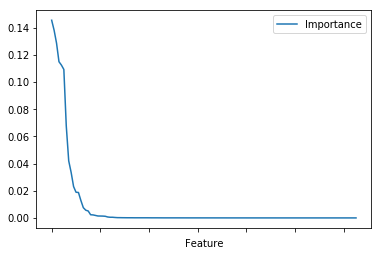

In [128]:
feature_importance.plot('Feature', 'Importance')

## Round 2 - Drop features after Feature Importance and find Correlations

### Create stats file and mark features to be dropped

In [130]:
df.shape

(172108, 126)

In [ ]:
#Get stats of modified dataset - dont run
'''stats_modified = pd.DataFrame({'nulls':df.isnull().sum(), 'type':df.dtypes})
stats_modified.reset_index(level=0, inplace=True)
stats_modified.columns = ['col', 'nulls', 'type']
stats_modified['pc_nulls'] = stats_modified['nulls']*100/df.shape[0]
stats_modified.to_csv('stats modified.csv')'''

In [132]:
# Import stats_modified after marking drop columns
stats_modified = pd.read_csv('stats modified.csv')

In [133]:
#Drop features selected manually
cols = stats_modified[stats_modified['drop'] == 'N']['col'].values
df = df[cols].copy()

In [134]:
df.shape

(172108, 105)

### Run RF model and find score

In [135]:
#Split the dataset into training and validation sets. Use 30,000 as the validation set
n_valid = 30000  
n_trn = len(df) - n_valid
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

In [136]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((142108, 105), (30000, 105), (142108,), (30000,))

In [137]:
#Run base model
m = RandomForestClassifier(n_jobs=-1)
m.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [138]:
#Predict validation set labels
preds = m.predict(X_valid)

In [139]:
#Calculate accuracy score
accuracy_score(y_valid, preds)

0.8998666666666667

### Feature importance 

In [140]:
#Use the feature importance to find the most important ones
feature_importance = pd.DataFrame({'Feature' : X_train.columns, 'Importance' : m.feature_importances_})
feature_importance.sort_values('Importance', ascending=False, inplace=True)
feature_importance.head(40)

,Feature,Importance
96,Amt Due Original USD,0.067490
103,#Dispute Types,0.062774
13,Tax Original USD,0.047272
95,Bill To Site Use ID,0.035259
91,Bill-To Cust#,0.034099
93,Bill-To Cust ID,0.031352
84,C20 Ucmid,0.026792
92,Bill-To Cust Name,0.026253
77,CA00 Account UCID,0.026067
90,C1 Account Name Customer Alias,0.023624


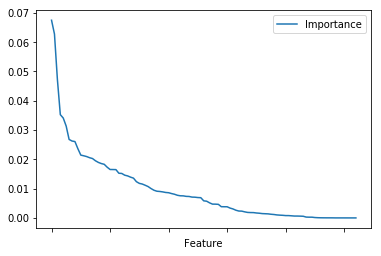

In [141]:
feature_importance.plot('Feature', 'Importance')

In [142]:
#The best cut off point seems to be 0.0.008 from figure
#Create dataset from important features
important_features = feature_importance[feature_importance['Importance'] > 0.008]
df_important = df[important_features['Feature']]


In [143]:
df_important.shape

(172108, 43)

In [144]:
df_important.columns

Index(['Amt Due Original USD', '#Dispute Types', 'Tax Original USD',
       'Bill To Site Use ID', 'Bill-To Cust#', 'Bill-To Cust ID', 'C20 Ucmid',
       'Bill-To Cust Name', 'CA00 Account UCID',
       'C1 Account Name Customer Alias', 'CA22 Primary Sales Rep',
       'CA99 Parent Account UCID', 'CA16 Primary SalesRep#',
       'CA15 Account Description', 'Cust Trx Type ID',
       'Amount Due Original USD Bin', 'CA18 DUNS Number', 'CA21 Primary CSM',
       'CA17 Primary CSM Num', 'CA4 Billing Analyst',
       'CA19 Acct 1st Became CustElapsed', 'C19 Parent UCMID',
       'CA19 Acct 1st Became CustDayofyear', 'Amt Adjusted USD %_na',
       'Due Elapsed', 'CA19 Acct 1st Became CustDay', 'C6 Invoice Split By',
       'days due', 'CA19 Acct 1st Became CustWeek', 'Trx Elapsed',
       'Bill-To Cust Country', 'Due Dayofyear', 'Amt Adjusted USD_na',
       'CA31 Pre-Delinquent Delivery', 'Trx Dayofyear', 'Due Week',
       'C9 Invoice Delivery Method', 'CA19 Acct 1st Became CustMonth',
 

### Run RF model with important features and calculate score

In [145]:
X_train, X_valid = split_vals(df_important, n_trn)
y_train, y_valid = split_vals(y, n_trn)

m = RandomForestClassifier(n_jobs=-1)
m.fit(X_train, y_train)
preds = m.predict(X_valid)
accuracy_score(y_valid, preds)

0.9074666666666666

### Draw dendrogram to see correlated features

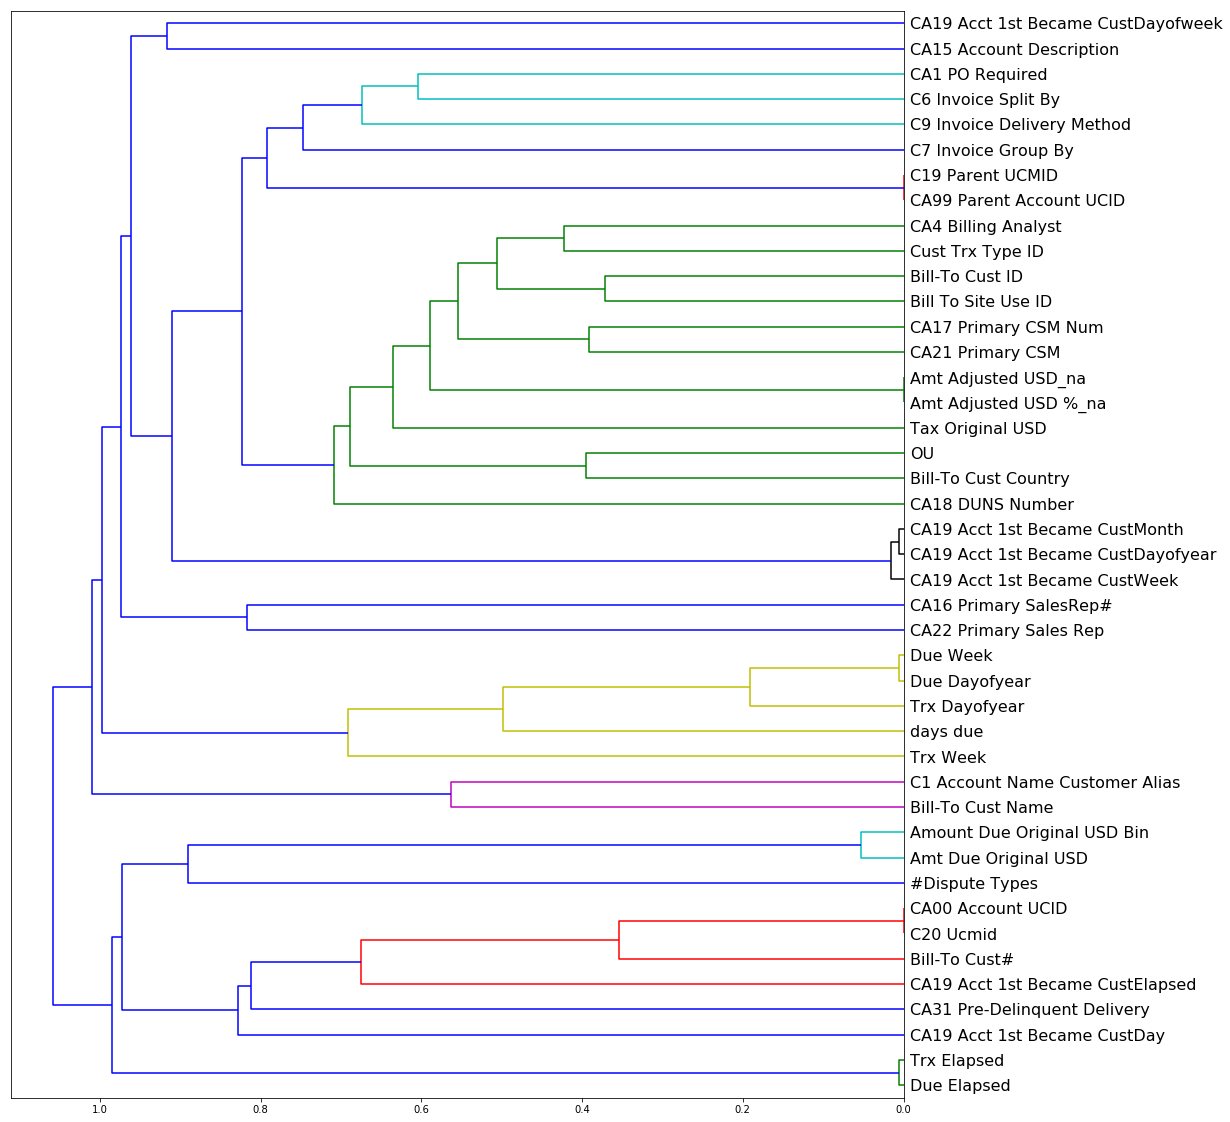

In [159]:
#Detect and remove redundant features
#Draw dendogram of feature clusters
corr = np.round(scipy.stats.spearmanr(df_important).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,20))
dendrogram = hc.dendrogram(z, labels=df_important.columns, orientation='left', leaf_font_size=16)
plt.show()

### Create dataframe of dendrogram leaf features and drop features with less impact on score

In [153]:
corr_features = pd.DataFrame({'feature':dendrogram.get('ivl')})

In [164]:
#Write correlated features to csv and mark correlated feature pairs as per diagram
corr_features.to_csv('corr features dendrogram.csv')

In [165]:
corr_features = pd.read_csv('corr features dendrogram.csv')

In [166]:
corr_features = corr_features[corr_features['correlated'] == 'Y'].copy()

In [167]:
corr_features.shape

(30, 3)

In [168]:
#Add columns to create sets of pairs of features which form a pair in the diagram
s = []
for i in np.arange(1,len(corr_features)/2+1,1):
    s.append(i)
    s.append(i)
corr_features['set'] = s

In [169]:
corr_features

,Unnamed: 0,feature,correlated,set
0,0,Due Elapsed,Y,1.0
1,1,Trx Elapsed,Y,1.0
6,6,C20 Ucmid,Y,2.0
7,7,CA00 Account UCID,Y,2.0
9,9,Amt Due Original USD,Y,3.0
10,10,Amount Due Original USD Bin,Y,3.0
11,11,Bill-To Cust Name,Y,4.0
12,12,C1 Account Name Customer Alias,Y,4.0
16,16,Due Dayofyear,Y,5.0
17,17,Due Week,Y,5.0


In [ ]:
### Drop features one by one and calculate the accuracy.  

In [172]:
#Drop features one by one and calculate accuracy
acc = []
for dropcol in corr_features.feature:
    
    X_train, X_valid = split_vals(df_important.drop(dropcol, axis=1), n_trn)
    y_train, y_valid = split_vals(y, n_trn)

    m = RandomForestClassifier(n_jobs=-1)
    m.fit(X_train, y_train)
    preds = m.predict(X_valid)
    
    acc.append(accuracy_score(y_valid, preds))
    print('Feature dropped:', dropcol, 'Accuracy:',accuracy_score(y_valid, preds))
    

Feature dropped: Due Elapsed Accuracy: 0.8984666666666666
Feature dropped: Trx Elapsed Accuracy: 0.9045666666666666
Feature dropped: C20 Ucmid Accuracy: 0.9015666666666666
Feature dropped: CA00 Account UCID Accuracy: 0.9065666666666666
Feature dropped: Amt Due Original USD Accuracy: 0.8973666666666666
Feature dropped: Amount Due Original USD Bin Accuracy: 0.9038
Feature dropped: Bill-To Cust Name Accuracy: 0.8995666666666666
Feature dropped: C1 Account Name Customer Alias Accuracy: 0.9052666666666667
Feature dropped: Due Dayofyear Accuracy: 0.9031
Feature dropped: Due Week Accuracy: 0.9036
Feature dropped: CA22 Primary Sales Rep Accuracy: 0.9007
Feature dropped: CA16 Primary SalesRep# Accuracy: 0.9042666666666667
Feature dropped: CA19 Acct 1st Became CustDayofyear Accuracy: 0.9017666666666667
Feature dropped: CA19 Acct 1st Became CustMonth Accuracy: 0.8998666666666667
Feature dropped: Bill-To Cust Country Accuracy: 0.9052333333333333
Feature dropped: OU Accuracy: 0.9006666666666666
Fea

In [174]:
corr_features['accuracy'] = acc

In [180]:
corr_features.sort_values(['set', 'accuracy'], inplace=True)
corr_features

,Unnamed: 0,feature,correlated,set,accuracy
0,0,Due Elapsed,Y,1.0,0.898467
1,1,Trx Elapsed,Y,1.0,0.904567
6,6,C20 Ucmid,Y,2.0,0.901567
7,7,CA00 Account UCID,Y,2.0,0.906567
9,9,Amt Due Original USD,Y,3.0,0.897367
10,10,Amount Due Original USD Bin,Y,3.0,0.903800
11,11,Bill-To Cust Name,Y,4.0,0.899567
12,12,C1 Account Name Customer Alias,Y,4.0,0.905267
16,16,Due Dayofyear,Y,5.0,0.903100
17,17,Due Week,Y,5.0,0.903600


In [181]:
#Drop features which have less impact when dropped, i.e. accuracy score is higher
corr_features.drop_duplicates(subset='set', keep='last', inplace=True)
corr_features

,Unnamed: 0,feature,correlated,set,accuracy
1,1,Trx Elapsed,Y,1.0,0.904567
7,7,CA00 Account UCID,Y,2.0,0.906567
10,10,Amount Due Original USD Bin,Y,3.0,0.903800
12,12,C1 Account Name Customer Alias,Y,4.0,0.905267
17,17,Due Week,Y,5.0,0.903600
19,19,CA16 Primary SalesRep#,Y,6.0,0.904267
21,21,CA19 Acct 1st Became CustDayofyear,Y,7.0,0.901767
24,24,Bill-To Cust Country,Y,8.0,0.905233
28,28,Amt Adjusted USD_na,Y,9.0,0.901267
29,29,CA21 Primary CSM,Y,10.0,0.902267


In [183]:
to_drop = corr_features.feature.values
to_drop

array(['Trx Elapsed', 'CA00 Account UCID', 'Amount Due Original USD Bin',
       'C1 Account Name Customer Alias', 'Due Week',
       'CA16 Primary SalesRep#', 'CA19 Acct 1st Became CustDayofyear',
       'Bill-To Cust Country', 'Amt Adjusted USD_na', 'CA21 Primary CSM',
       'Bill To Site Use ID', 'Cust Trx Type ID', 'C19 Parent UCMID',
       'CA1 PO Required', 'CA15 Account Description'], dtype=object)

In [184]:
df_important = df_important.drop(to_drop, axis=1)

In [185]:
df_important.shape

(172108, 28)

### Run RF again after dropping correlated features and check score

In [186]:
X_train, X_valid = split_vals(df_important, n_trn)
y_train, y_valid = split_vals(y, n_trn)

m = RandomForestClassifier(n_jobs=-1)
m.fit(X_train, y_train)
preds = m.predict(X_valid)
accuracy_score(y_valid, preds)

0.9002

### Feature Importance

In [187]:
#Use the feature importance to find the most important ones
feature_importance = pd.DataFrame({'Feature' : X_train.columns, 'Importance' : m.feature_importances_})
feature_importance.sort_values('Importance', ascending=False, inplace=True)
feature_importance.head(40)

,Feature,Importance
0,Amt Due Original USD,0.099341
1,#Dispute Types,0.067451
2,Tax Original USD,0.066454
3,Bill-To Cust#,0.062283
4,Bill-To Cust ID,0.061137
5,C20 Ucmid,0.051459
6,Bill-To Cust Name,0.047659
10,CA17 Primary CSM Num,0.039757
7,CA22 Primary Sales Rep,0.039322
8,CA99 Parent Account UCID,0.036939


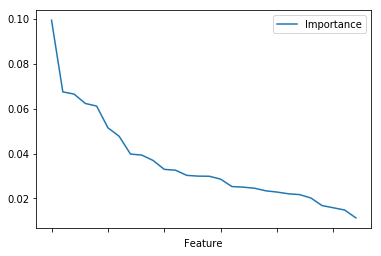

In [189]:
feature_importance.plot('Feature', 'Importance')

Graph does not plateau and hence do not take cut off to drop features

### Draw dendrogram to see correlated features

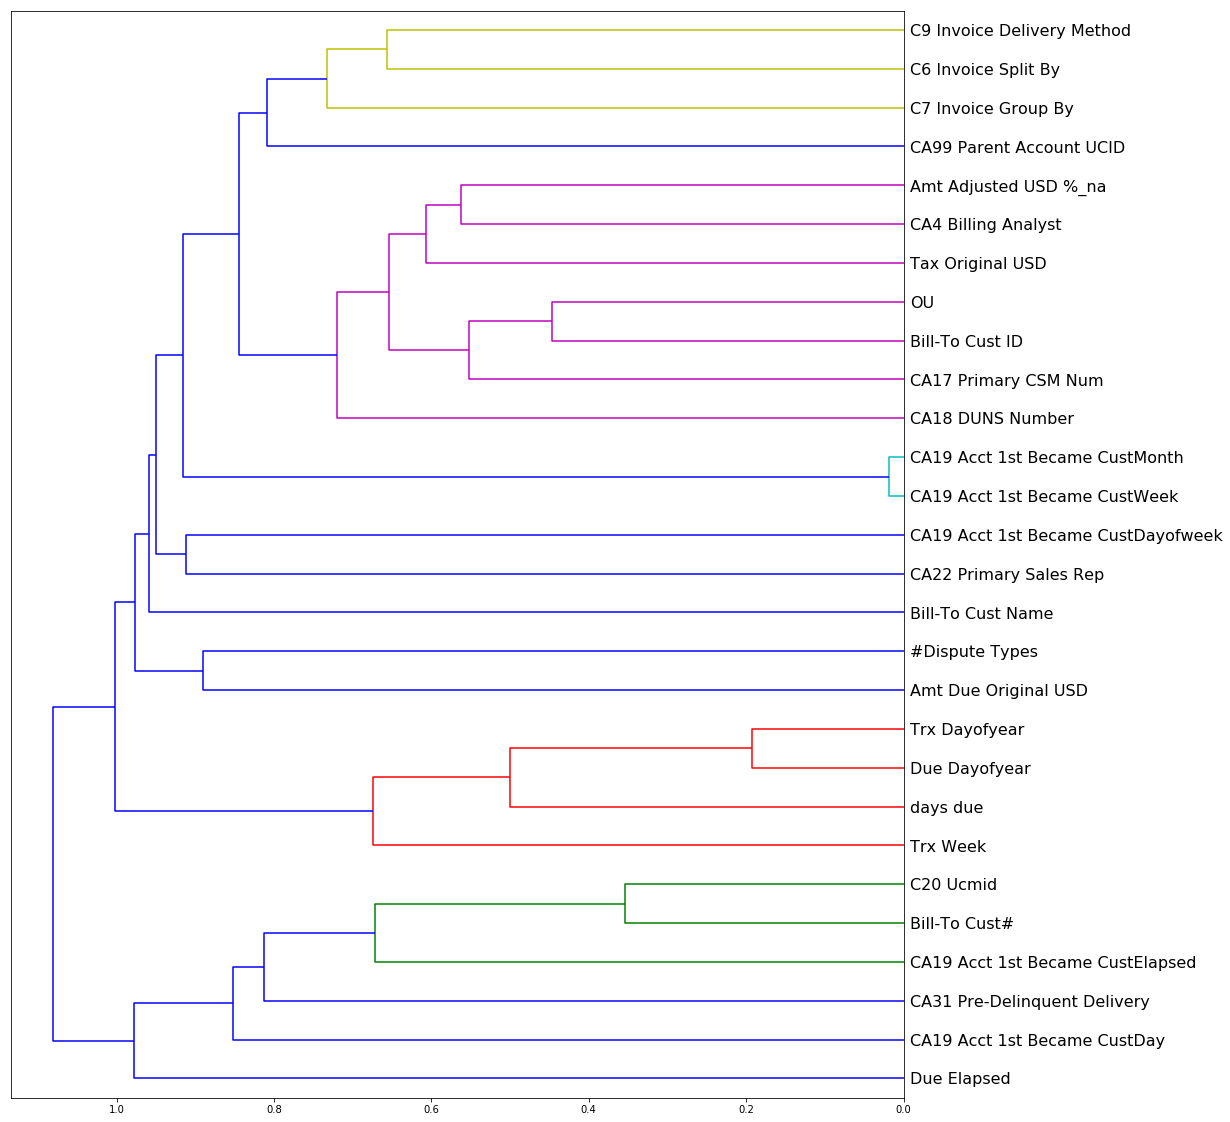

In [188]:
#Detect and remove redundant features
#Draw dendogram of feature clusters
corr = np.round(scipy.stats.spearmanr(df_important).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,20))
dendrogram = hc.dendrogram(z, labels=df_important.columns, orientation='left', leaf_font_size=16)
plt.show()

Stopping here 

## Round 3 - Use feature correlation

### Find correlation between features

In [190]:
df.shape

(172108, 105)

In [191]:
corr_matrix = df.corr().abs()

In [192]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [195]:
# Find index of feature columns with correlation greater than 0.80
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

In [196]:
to_drop

['Trx Month',
 'Trx Is_month_end',
 'Trx Elapsed',
 'Trx Dayofyear',
 'Trx Dayofweek',
 'Due Year',
 'Due Week',
 'Due Month',
 'Due Elapsed',
 'Due Dayofyear',
 'Due Day',
 'days due',
 'Cust Trx Type ID',
 'Converted',
 'CA8 Currency Code',
 'CA30 Email 0 Amt Trx',
 'CA3 Region',
 'CA19 Acct 1st Became CustWeek_na',
 'CA19 Acct 1st Became CustMonth_na',
 'CA19 Acct 1st Became CustMonth',
 'CA19 Acct 1st Became CustElapsed',
 'CA19 Acct 1st Became CustDayofyear_na',
 'CA19 Acct 1st Became CustDayofyear',
 'CA19 Acct 1st Became CustDayofweek_na',
 'CA19 Acct 1st Became CustDay_na',
 'C20 Ucmid',
 'C19 Parent UCMID',
 'C12 Preferred Document Lang',
 'Amt Adjusted USD %_na',
 'Amount Due Original USD Bin',
 '#Adjustment Types']

In [181]:
df.shape

(172108, 105)

In [189]:
#Drop features one by one and calculate accuracy
acc = []
for dropcol in feature_importance.Feature:
    
    X_train, X_valid = split_vals(df.drop(dropcol, axis=1), n_trn)
    y_train, y_valid = split_vals(y, n_trn)

    m = RandomForestClassifier(n_jobs=-1)
    m.fit(X_train, y_train)
    preds = m.predict(X_valid)
    
    acc.append(accuracy_score(y_valid, preds))
    #print('Feature dropped:', dropcol, 'Accuracy:',accuracy_score(y_valid, preds))
    #df_feature_drop = pd.DataFrame

In [190]:
feature_importance['accuracy_after_drop'] = acc
feature_importance.sort_values('accuracy_after_drop', ascending=True, inplace=True)
feature_importance.head(30)

,Feature,Importance,accuracy_after_drop
103,#Dispute Types,0.059639,0.893133
29,Due Is_month_end,0.002196,0.896867
52,CA19 Acct 1st Became CustYear_na,0.000084,0.896933
27,Due Is_quarter_end,0.001776,0.897900
61,CA19 Acct 1st Became CustIs_quarter_end,0.000710,0.898100
0,Trx Year,0.001488,0.898833
15,Region,0.002011,0.899133
96,Amt Due Original USD,0.066748,0.899233
68,CA19 Acct 1st Became CustDayofweek,0.007655,0.899333
88,C11 SUPERKEY / KEY Customer,0.005894,0.899433


In [193]:
feature_importance.head(10)['Feature'].values

array(['#Dispute Types', 'Due Is_month_end',
       'CA19 Acct 1st Became CustYear_na', 'Due Is_quarter_end',
       'CA19 Acct 1st Became CustIs_quarter_end', 'Trx Year', 'Region',
       'Amt Due Original USD', 'CA19 Acct 1st Became CustDayofweek',
       'C11 SUPERKEY / KEY Customer'], dtype=object)

In [166]:
# Run the model for various cut off values for the importance to find the best set of importance features
for i in [0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]:
    important_features = feature_importance[feature_importance['Importance'] > i]
    df_important = df[important_features['Feature']]
    X_train, X_valid = split_vals(df_important, n_trn)
    y_train, y_valid = split_vals(y, n_trn)

    m = RandomForestClassifier(n_jobs=-1)
    m.fit(X_train, y_train)
    preds = m.predict(X_valid)
    
    print('Cut off:',i, 'Accuracy:',accuracy_score(y_valid, preds))


Cut off: 0.008 Accuracy: 0.9027
Cut off: 0.009 Accuracy: 0.8995666666666666
Cut off: 0.01 Accuracy: 0.9007666666666667
Cut off: 0.02 Accuracy: 0.9046666666666666
Cut off: 0.03 Accuracy: 0.9075333333333333
Cut off: 0.04 Accuracy: 0.861
Cut off: 0.05 Accuracy: 0.8462
Cut off: 0.06 Accuracy: 0.8496


Best cut off = 0.03.  The most significant features are below

Amt Due Original USD
#Dispute Types
Tax Original USD
Bill To Site Use
Bill-To Cust#

## Round 4 - Add features based on frequency of values

Fresh data analysis based on learnings from other sections.
- drop columns with more than 70% nulls
- drop columns in Pankaj's email
- drop id columns with a high number of values
- drop some other columns after doing correlation 
- add columns to group values where unique values is less in number 

In [74]:
#Manually analyze each column in raw dataset and delete unwanted columns and import stats
stats = pd.read_csv('stats.csv')

In [52]:
stats.head()

,Unnamed: 0,col,nulls,type,pc_nulls,drop,to_type,normal,Unnamed: 8
0,26,C16 Dunning Language Print,172108,float64,100.000000,Y,no change,NaN,NaN
1,64,CA32 Ops Account Number,172108,float64,100.000000,Y,NaN,NaN,NaN
2,56,CA25 Reseller Account Number,172107,float64,99.999419,Y,NaN,NaN,NaN
3,11,Amt in Inv Dispute USD,172105,object,99.998257,Y,NaN,NaN,NaN
4,43,CA13 Substantial Party Curr,171858,object,99.854742,Y,NaN,NaN,NaN


In [75]:
use_cols = stats[stats['drop'] == 'N']['col'].values
df = invoices[use_cols].copy()

In [76]:
#Change to category type
cats = stats[(stats['to_type'] == 'category') & (stats['drop'] == 'N')]['col']
for i in cats:
    df[i] = df[i].astype('category')


In [77]:
#Change to float type
floats = stats[(stats['to_type'] == 'float') & (stats['drop'] == 'N')]['col']
for i in floats:
    df[i] = df[i].astype('float')

In [78]:
dates = stats[(stats['to_type'] == 'datetime') & (stats['drop'] == 'N')]['col']
for k in dates:
    df[k] = pd.to_datetime(df[k])

In [79]:
df.shape

(172108, 33)

In [80]:
#Change dates to dateparts
for date_cols in dates:
    add_datepart(df, date_cols)

In [81]:
df.shape

(172108, 69)

In [82]:
invoices['xNot Fully Paid Invoices'].value_counts()

0    145221
1     26887
Name: xNot Fully Paid Invoices, dtype: int64

In [83]:
#Change all category variables into code
df, y, nas = proc_df(df, 'xNot Fully Paid Invoices')

In [109]:
#Add 1 if value is 2 and 0 if not
df['Interface Header Context - Normal'] = np.where(df['Interface Header Context']==df['Interface Header Context'].value_counts().head(1).index[0], 1, 0)

In [113]:
#Add 1 if value is the highest count and 0 if not
normals = stats[(stats['normal'] == 'Y')]['col']
for col in normals:
    df[col + 'Normal'] = np.where(df[col]==df[col].value_counts().head(1).index[0], 1, 0)

In [121]:
#Add 1 if value of the highest value of Trx Day as 1 and 0 if not
df['Trx Day' + 'Normal'] = np.where(df['Trx Day']==df['Trx Day'].value_counts().head(1).index[0], 1, 0)

In [122]:
df.to_csv('Equinix Invoices - modified dataset2.csv')

In [123]:
#Split the dataset into training and validation sets. Use 30,000 as the validation set
n_valid = 30000  
n_trn = len(df) - n_valid
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

In [124]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((142108, 87), (30000, 87), (142108,), (30000,))

In [125]:
#Run base model
m = RandomForestClassifier(n_jobs=-1)
m.fit(X_train, y_train)

#Predict validation set labels
preds = m.predict(X_valid)

#Calculate accuracy score
accuracy_score(y_valid, preds)

0.9912

In [126]:
#Use the feature importance to find the most important ones
feature_importance = pd.DataFrame({'Feature' : X_train.columns, 'Importance' : m.feature_importances_})
feature_importance.sort_values('Importance', ascending=False, inplace=True)
feature_importance.head(30)

,Feature,Importance
16,Amt Due Remaining USD,0.423297
4,Delinquency Status,0.210107
3,Credit Applied USD,0.161293
69,Credit Applied USD_na,0.035056
1,Dispute Type,0.018425
15,Amt Due Original USD,0.014112
68,Amt Adjusted USD_na,0.013212
41,CA19 Acct 1st Became CustElapsed,0.008328
2,Amt Adjusted USD,0.007976
17,Bill To Site Use ID,0.007919


In [131]:
feature_importance['Importance'].sum()

1.0000000000000002

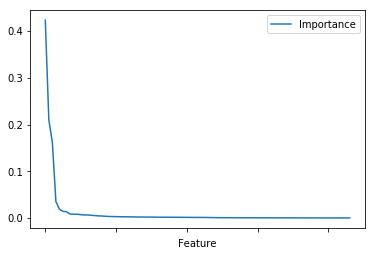

In [127]:
feature_importance.plot('Feature', 'Importance')

In [128]:
#The best cut off point seems to be 0.002 from figure
#Create dataset from important features
important_features = feature_importance[feature_importance['Importance'] > 0.002]
df_important = df[important_features['Feature']]

In [129]:
# Run RF second round
X_train, X_valid = split_vals(df_important, n_trn)
y_train, y_valid = split_vals(y, n_trn)

m = RandomForestClassifier(n_jobs=-1)
m.fit(X_train, y_train)
preds = m.predict(X_valid)
accuracy_score(y_valid, preds)

0.9951666666666666

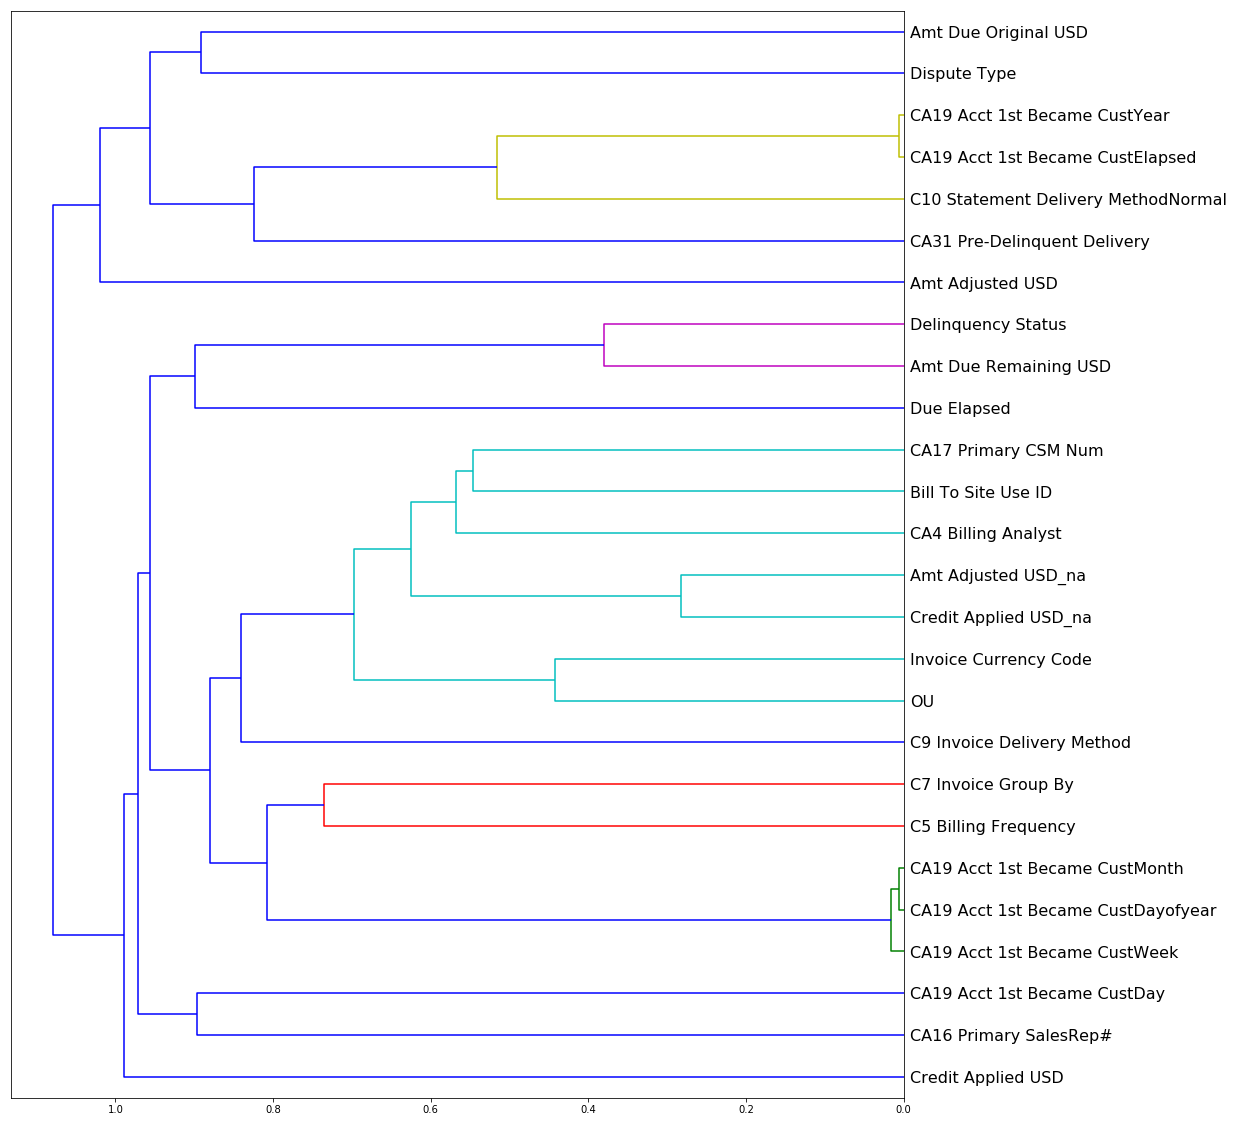

In [130]:
#Detect and remove redundant features
#Draw dendogram of feature clusters
corr = np.round(scipy.stats.spearmanr(df_important).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,20))
dendrogram = hc.dendrogram(z, labels=df_important.columns, orientation='left', leaf_font_size=16)
plt.show()

## Round 5 - Sort rows on invoice date and use as time series

In [213]:
invoices.shape

(172108, 137)

In [214]:
invoices.sort_values('Trx Date', inplace=True)

In [215]:
stats = pd.read_csv('stats.csv')

In [216]:
#Drop cols based on null percentage
use_cols = stats[stats['drop'] == 'N']['col'].values
df = invoices[use_cols].copy()

#Remove % sign from columns
df['Amt Adjusted USD %'] = df['Amt Adjusted USD %'].str.replace('\%', '')
df['Amt Paid USD %'] = df['Amt Paid USD %'].str.replace('\%', '')
df['Credit Applied USD %'] = df['Credit Applied USD %'].str.replace('\%', '')
df['Amt Due Remaining USD %'] = df['Amt Due Remaining USD %'].str.replace('\%', '')
df['Inv Amt Paid USD % '] = df['Inv Amt Paid USD % '].str.replace('\%', '')
df['Write Off %'] = df['Write Off %'].str.replace('\%', '')
df['Inv Amt Paid USD %  Bin'] = df['Inv Amt Paid USD %  Bin'].str.replace('\%', '')

#Change to category type
cats = stats[(stats['to_type'] == 'category') & (stats['drop'] == 'N')]['col']
for i in cats:
    df[i] = df[i].astype('category')
    
#Change to float type
floats = stats[(stats['to_type'] == 'float') & (stats['drop'] == 'N')]['col']
for i in floats:
    df[i] = df[i].astype('float')

#Change to datetime
dates = stats[(stats['to_type'] == 'datetime') & (stats['drop'] == 'N')]['col']
for k in dates:
    df[k] = pd.to_datetime(df[k])

#Change dates to dateparts
for date_cols in dates:
    add_datepart(df, date_cols)
    
#Change all category variables into code
df, y, nas = proc_df(df, 'xNot Fully Paid Invoices')

In [231]:
# Import stats_modified after marking drop columns
stats_modified = pd.read_csv('stats modified.csv')

In [232]:
#Drop features selected manually
cols = stats_modified[stats_modified['drop'] == 'N']['col'].values
df = df[cols].copy()

In [233]:
df.shape

(172108, 105)

In [234]:
#Split the dataset into training and validation sets. Use 30,000 latest rows as the validation set
X_valid = df.tail(30000)
X_train = df.drop(X_valid.index)
y_valid = y[-30000:]
y_train = y[:142108]
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((142108, 105), (30000, 105), (142108,), (30000,))

In [236]:
#Run base model
m = RandomForestClassifier(n_jobs=-1)
m.fit(X_train, y_train)

#Predict validation set labels
preds = m.predict(X_valid)
preds_train = m.predict(X_train)

#Calculate accuracy score
print('Validation score:', accuracy_score(y_valid, preds))
print('Train score:', accuracy_score(y_train, preds_train))

Validation score: 0.8902333333333333
Train score: 0.987220986855068


In [226]:
#Use the feature importance to find the most important ones
feature_importance = pd.DataFrame({'Feature' : X_train.columns, 'Importance' : m.feature_importances_})
feature_importance.sort_values('Importance', ascending=False, inplace=True)
feature_importance.head(30)

,Feature,Importance
63,xFully Paid Invoices,0.241457
64,Write Off %,0.166740
67,Inv Amt Paid USD % Bin,0.094355
119,Amt Paid USD_na,0.081091
74,Tax Remaining USD,0.077472
46,Inv Amt Paid USD %,0.069867
118,Amt Paid USD %_na,0.068140
59,Writeoff,0.067221
18,Amt Paid USD %,0.030726
7,Credit Applied USD,0.024274


In [ ]:
feature_importance.plot('Feature', 'Importance')

## Round 6 -  Selected column list and calculated columns

In [5]:
#Import data
invoices = pd.read_csv('AR sub.csv', low_memory=False, parse_dates=['Due Date', 'Trx Date', 'GL Date Closed'])

In [6]:
invoices.columns

Index(['Amt Due Original USD', 'Bill-To Cust Country', 'Bill-To Cust ID',
       'C5 Billing Frequency', 'C9 Invoice Delivery Method',
       'CA16 Primary SalesRep#', 'CA17 Primary CSM Num', 'CA4 Billing Analyst',
       'Due Date', 'GL Date Closed', 'Payment Schedule ID', 'Payment Terms',
       'Trx Date', 'DisputeType'],
      dtype='object')

In [7]:
#Rename columns for convenience
invoices.columns = ['InvoiceAmt', 'CustomerCountry', 'CustomerID',
       'BillingFrequency', 'InvoiceDeliveryMethod', 'PrimarySalesRep',
       'PrimaryCSM', 'BillingAnalyst', 'DueDate',
       'GLDateClosed','PaymentScheduleID', 'PaymentTerms','TrxDate', 'DisputeType']

In [8]:
invoices.isnull().sum()

InvoiceAmt                    0
CustomerCountry               4
CustomerID                    0
BillingFrequency              0
InvoiceDeliveryMethod         0
PrimarySalesRep           15499
PrimaryCSM                44961
BillingAnalyst            32546
DueDate                       0
GLDateClosed                  0
PaymentScheduleID             0
PaymentTerms                  0
TrxDate                       0
DisputeType              165143
dtype: int64

In [9]:
invoices.dtypes

InvoiceAmt                      float64
CustomerCountry                  object
CustomerID                        int64
BillingFrequency                 object
InvoiceDeliveryMethod            object
PrimarySalesRep                 float64
PrimaryCSM                      float64
BillingAnalyst                  float64
DueDate                  datetime64[ns]
GLDateClosed                     object
PaymentScheduleID                 int64
PaymentTerms                     object
TrxDate                  datetime64[ns]
DisputeType                      object
dtype: object

In [10]:
#Create Paid column
invoices['Paid'] = 1

In [11]:
#Mark rows with date as 12/31/4712 as Unpaid
invoices.loc[invoices['GLDateClosed'] == '12/31/4712', 'Paid'] = 0

In [12]:
#Create a Dispute y and n column
invoices['Dispute'] = np.where(invoices['DisputeType'].isnull(), 0, 1)
#invoices.drop(['DisputeType'], axis=1)

In [13]:
#Change large date to something reasonable
invoices.loc[invoices['GLDateClosed']=='12/31/4712', 'GLDateClosed'] = '12/31/1970'

In [14]:
#Change to datetime
invoices['GLDateClosed'] = pd.to_datetime(invoices['GLDateClosed'])


In [15]:
#Calculate age of all invoice payments
invoices['DaysLate'] = (invoices['GLDateClosed'] - invoices['DueDate']).dt.days

In [16]:
#Set days late for all unpaid invoices to 0
invoices.loc[invoices['GLDateClosed'] == '1970-12-31','DaysLate'] = 0

In [32]:
customers = invoices['CustomerID'].unique()

In [62]:
df = pd.DataFrame(data=None, columns=sub.columns)

In [64]:
#Process each customer's data separately, calculate various counts and sums of paid/unpaid invoices
#and append to a blank dataframe
#For all combinations of Paid/Unpaid, Late/not late calculate sums and counts of inovices and find ratios
#c = 0
for cust in customers:
    #Extract a customers data for sample
    sub = invoices[invoices['CustomerID'] == cust]
    #Number of total paid invoices
    sub['count_paid_full'] = len(sub[sub['Paid'] == 1])
    #Number of invoices that were paid late
    sub['count_paid_late'] = len(sub[sub['DaysLate'] > 0])
    #Ratio of paid invoices that were late
    sub['ratio_paid_late'] = sub['count_paid_late']/sub['count_paid_full']
    #Sum of the base amount of total paid invoices
    sub['sum_paid_full'] = sub[sub['Paid'] == 1]['InvoiceAmt'].sum()
    #Sum of the base amount of invoices that were paid late
    sub['sum_paid_late'] = sub[sub['DaysLate'] > 0]['InvoiceAmt'].sum()
    #Ratio of sum of paid base amount that were late
    sub['ratio_sum_late_full'] = sub['sum_paid_late']/sub['sum_paid_full']
    #Average days late of paid invoices being late.
    sub['avg_paid_late'] = sub[sub['DaysLate'] > 0]['DaysLate'].mean()
    #Number of total outstanding invoices
    sub['count_not_paid'] = len(sub[sub['Paid'] == 0])
    #Number of outstanding invoices that were already late
    #6/1/2017 is assumed to be date when this extract was pulled
    sub['count_outstanding_late'] = len(sub[(sub['Paid'] == 0) & (sub['DueDate'] < '2017-06-01')])
    #Ratio of outstanding invoices that were late
    sub['ratio_unpaid_late'] = sub['count_not_paid']/sub['count_outstanding_late']\
    #Sum of the base amount of total outstanding invoices
    sub['sum_not_paid'] = sub[sub['Paid'] == 0]['InvoiceAmt'].sum()
    #Sum of the base amount of outstanding invoices that were late
    sub['sum_outstanding_late'] = sub[(sub['Paid'] == 0) & (sub['DueDate'] < '2017-06-01')]['InvoiceAmt'].sum()
    #Ratio of sum of outstanding base amount that were late
    sub['ratio_sum_unpaid_late'] = sub['sum_not_paid']/sub['sum_outstanding_late']
    #Average days late of outstanding invoices being late.
    sub['avg_outstanding_late'] = sub[(sub['Paid'] == 0) & (sub['DueDate'] < '2017-06-01')]['InvoiceAmt'].mean()
    df = df.append(sub)
    #c = c + 1
    #print(c)
    


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338


6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977


8417
8418
8419
8420
8421
8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616


10047
10048
10049
10050
10051
10052
10053
10054
10055
10056
10057
10058
10059
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
1021

11413
11414
11415
11416
11417
11418
11419
11420
11421
11422
11423
11424
11425
11426
11427
11428
11429
11430
11431
11432
11433
11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
1157

12779
12780
12781
12782
12783
12784
12785
12786
12787
12788
12789
12790
12791
12792
12793
12794
12795
12796
12797
12798
12799
12800
12801
12802
12803
12804
12805
12806
12807
12808
12809
12810
12811
12812
12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
1294

In [65]:
df.shape

(172108, 31)

In [66]:
#df.to_csv('df with calc cols.csv')

In [17]:
#Import saved and processed data
df = pd.read_csv('df with calc cols.csv')

In [18]:
df.isnull().sum()

Unnamed: 0                     0
InvoiceAmt                     0
CustomerCountry                4
CustomerID                     0
BillingFrequency               0
InvoiceDeliveryMethod          0
PrimarySalesRep            15499
PrimaryCSM                 44961
BillingAnalyst             32546
DueDate                        0
GLDateClosed                   0
PaymentScheduleID              0
PaymentTerms                   0
TrxDate                        0
DisputeType               165143
Paid                           0
Dispute                        0
DaysLate                       0
count_paid_full                0
count_paid_late                0
ratio_paid_late             2565
sum_paid_full                  0
sum_paid_late                  0
ratio_sum_late_full         2565
avg_paid_late              14010
count_not_paid                 0
count_outstanding_late         0
ratio_unpaid_late          99743
sum_not_paid                   0
sum_outstanding_late           0
ratio_sum_

In [19]:
#Fill NA for calculated fields with 0
df.ratio_paid_late.fillna(0,inplace=True)
df.ratio_sum_late_full.fillna(0,inplace=True)
df.avg_paid_late.fillna(0,inplace=True)
df.ratio_unpaid_late.fillna(0,inplace=True)
df.ratio_sum_unpaid_late.fillna(0,inplace=True)
df.avg_outstanding_late.fillna(0,inplace=True)

In [20]:
#Set DaysLate -ve to 0
df['DaysLateLabel'] = np.where(df['DaysLate'] < 0, 0, df['DaysLate'])

In [21]:
#DaysLate buckets
df['DaysLateBins'] = pd.cut(df['DaysLateLabel'], bins=[0.0,30.0,60.0,90.0, 10000], labels=[1,2,3,4], include_lowest=True) 

In [22]:
df.head()

,Unnamed: 0,InvoiceAmt,CustomerCountry,CustomerID,BillingFrequency,InvoiceDeliveryMethod,PrimarySalesRep,PrimaryCSM,BillingAnalyst,DueDate,...,avg_paid_late,count_not_paid,count_outstanding_late,ratio_unpaid_late,sum_not_paid,sum_outstanding_late,ratio_sum_unpaid_late,avg_outstanding_late,DaysLateLabel,DaysLateBins
0,0,20309.83,DE,116392,Monthly,Email and Print,1815.0,10619.0,7317.0,2016-08-24,...,69.282051,5,5,1.0,302380.72,302380.72,1.0,60476.144,47,2
1,6037,94545.86,DE,116392,Monthly,Email and Print,1815.0,10619.0,7317.0,2016-08-31,...,69.282051,5,5,1.0,302380.72,302380.72,1.0,60476.144,49,2
2,6277,61198.95,DE,116392,Monthly,Email and Print,1815.0,10619.0,7317.0,2016-10-31,...,69.282051,5,5,1.0,302380.72,302380.72,1.0,60476.144,0,1
3,7186,77.13,DE,116392,Monthly,Email and Print,1815.0,10619.0,7317.0,2017-03-03,...,69.282051,5,5,1.0,302380.72,302380.72,1.0,60476.144,4,1
4,7187,77.13,DE,116392,Monthly,Email and Print,1815.0,10619.0,7317.0,2017-03-03,...,69.282051,5,5,1.0,302380.72,302380.72,1.0,60476.144,4,1


In [ ]:
'''#Extract stats for processing
stats3 = pd.DataFrame({'nulls':df.isnull().sum(), 'type':df.dtypes})
stats3.reset_index(level=0, inplace=True)
stats3.columns = ['col', 'nulls', 'type']
stats3['pc_nulls'] = stats3['nulls']*100/df.shape[0]
stats3.to_csv('stats3.csv')'''

In [23]:
#Import modified stats
stats_import = pd.read_csv('stats3.csv')

In [24]:
stats_import.head()

,Unnamed: 0,col,nulls,type,pc_nulls,drop,to_type
0,0,InvoiceAmt,0,float64,0.000000,N,no change
1,1,CustomerCountry,4,object,0.002324,N,category
2,2,CustomerID,0,object,0.000000,N,category
3,3,BillingFrequency,0,object,0.000000,N,category
4,4,InvoiceDeliveryMethod,0,object,0.000000,N,category


In [25]:
#Change to category type
cats = stats_import[stats_import['to_type'] == 'category']['col']
for i in cats:
    df[i] = df[i].astype('category')   


In [26]:
#Change to bool type
bools = stats_import[stats_import['to_type'] == 'bool']['col']
for i in bools:
    df[i] = df[i].astype('bool')

In [27]:
#Change to integer type
integers = stats_import[stats_import['to_type'] == 'integer']['col']
for i in integers:
    df[i] = df[i].astype('int')

In [28]:
#Drop unnecessary or correlated columns
to_drop = stats_import[stats_import['drop'] == 'Y']['col']
df.drop(to_drop, axis=1, inplace=True)

In [29]:
#drop index from original dataset
df.drop('Unnamed: 0', axis=1, inplace=True)

In [30]:
df.shape

(172108, 28)

In [31]:
#Change Trxdate to datetime
df['TrxDate'] = pd.to_datetime(df['TrxDate'])

In [32]:
#Change dates to dateparts
add_datepart(df, 'TrxDate')

In [33]:
df.dtypes

InvoiceAmt                 float64
CustomerCountry           category
CustomerID                category
BillingFrequency          category
InvoiceDeliveryMethod     category
PrimarySalesRep           category
PrimaryCSM                category
BillingAnalyst            category
PaymentScheduleID         category
PaymentTerms              category
DisputeType               category
Dispute                       bool
count_paid_full              int32
count_paid_late              int32
ratio_paid_late            float64
sum_paid_full              float64
sum_paid_late              float64
ratio_sum_late_full        float64
avg_paid_late              float64
count_not_paid               int32
count_outstanding_late       int32
ratio_unpaid_late          float64
sum_not_paid               float64
sum_outstanding_late       float64
ratio_sum_unpaid_late      float64
avg_outstanding_late       float64
DaysLateBins              category
TrxYear                      int64
TrxMonth            

In [34]:
#Change all category variables into code and add missing values 
df, y, nas = proc_df(df, 'DaysLateBins')

In [35]:
df.isnull().sum()

InvoiceAmt                0
CustomerCountry           0
CustomerID                0
BillingFrequency          0
InvoiceDeliveryMethod     0
PrimarySalesRep           0
PrimaryCSM                0
BillingAnalyst            0
PaymentScheduleID         0
PaymentTerms              0
DisputeType               0
Dispute                   0
count_paid_full           0
count_paid_late           0
ratio_paid_late           0
sum_paid_full             0
sum_paid_late             0
ratio_sum_late_full       0
avg_paid_late             0
count_not_paid            0
count_outstanding_late    0
ratio_unpaid_late         0
sum_not_paid              0
sum_outstanding_late      0
ratio_sum_unpaid_late     0
avg_outstanding_late      0
TrxYear                   0
TrxMonth                  0
TrxWeek                   0
TrxDay                    0
TrxDayofweek              0
TrxDayofyear              0
TrxIs_month_end           0
TrxIs_month_start         0
TrxIs_quarter_end         0
TrxIs_quarter_start 

In [36]:
#Split the dataset into training and validation sets. Use 30,000 as the validation set
n_valid = 30000  
n_trn = len(df) - n_valid
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

In [37]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((142108, 39), (30000, 39), (142108,), (30000,))

In [38]:
#Run base model
m = RandomForestClassifier(n_jobs=-1)
m.fit(X_train, y_train)

#Predict validation set labels
preds = m.predict(X_valid)

#Calculate accuracy score
accuracy_score(y_valid, preds)

0.8019666666666667

In [39]:
#Use the feature importance to find the most important ones
feature_importance = pd.DataFrame({'Feature' : X_train.columns, 'Importance' : m.feature_importances_})
feature_importance.sort_values('Importance', ascending=False, inplace=True)
feature_importance.head(30)

,Feature,Importance
8,PaymentScheduleID,0.151459
18,avg_paid_late,0.151211
0,InvoiceAmt,0.101332
17,ratio_sum_late_full,0.041035
2,CustomerID,0.034782
14,ratio_paid_late,0.034376
16,sum_paid_late,0.033943
13,count_paid_late,0.031379
15,sum_paid_full,0.031040
38,TrxElapsed,0.029507


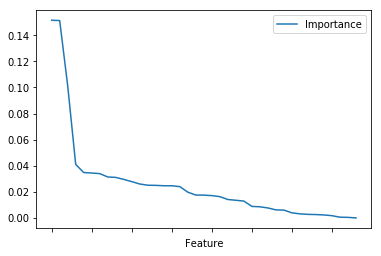

In [40]:
feature_importance.plot('Feature', 'Importance')

In [41]:
#The best cut off point seems to be 0.02 from figure
#Create dataset from important features
important_features = feature_importance[feature_importance['Importance'] > 0.02]
df_important = df[important_features['Feature']]

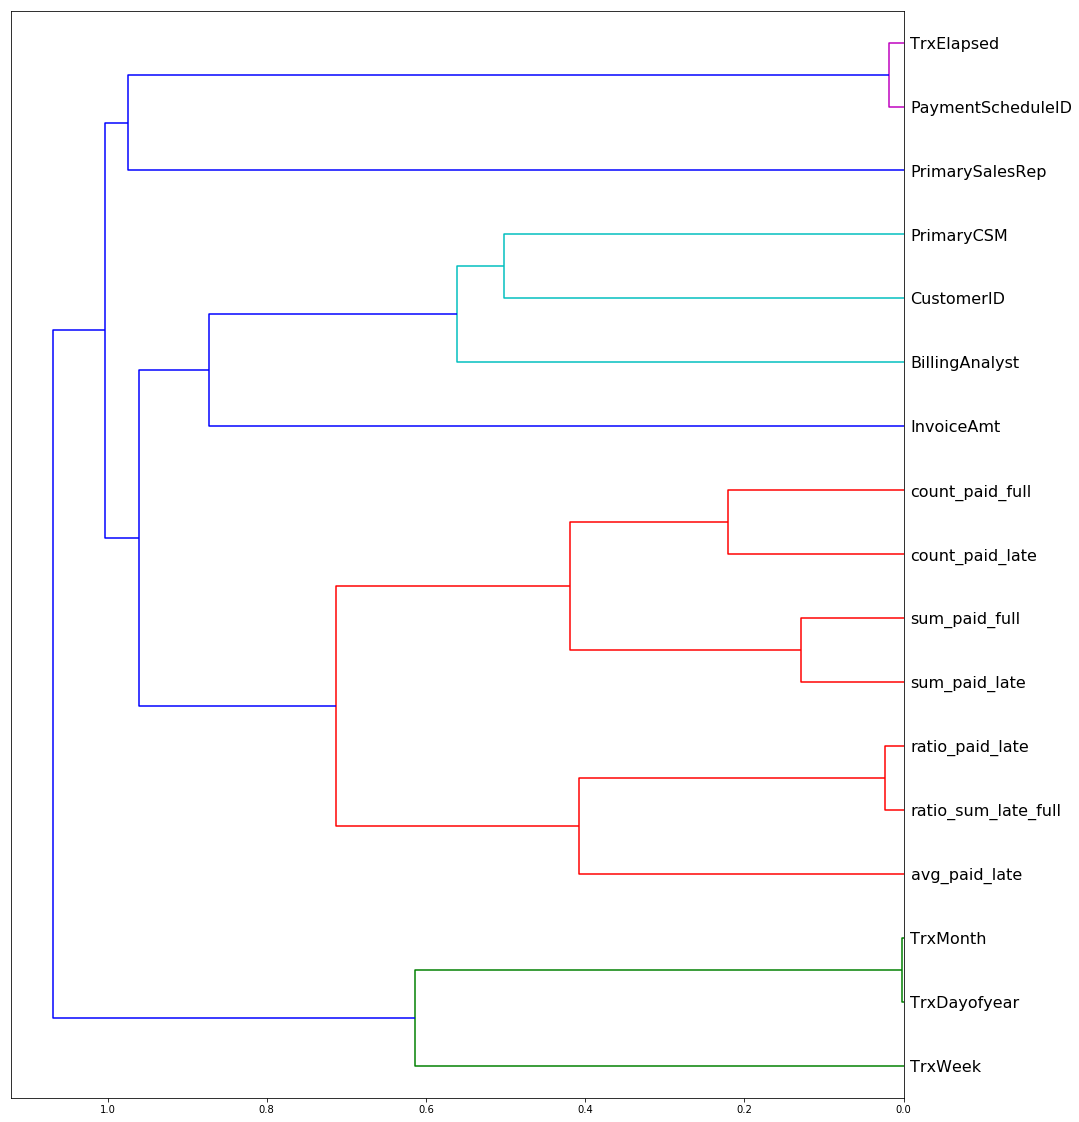

In [49]:
#Detect and remove redundant features
#Draw dendogram of feature clusters
corr = np.round(scipy.stats.spearmanr(df_important).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,20))
dendrogram = hc.dendrogram(z, labels=df_important.columns, orientation='left', leaf_font_size=16)
plt.show()

In [43]:
### Create dataframe of dendrogram leaf features and drop features with less impact on score
corr_features = pd.DataFrame({'feature':dendrogram.get('ivl')})

#Write correlated features to csv and mark correlated feature pairs as per diagram
corr_features.to_csv('corr features dendrogram round 6.csv')

In [53]:
corr_features = pd.read_csv('corr features dendrogram round 6.csv')
corr_features = corr_features[corr_features['correlated'] == 'Y'].copy()
corr_features.shape

(12, 3)

In [54]:
corr_features

,Unnamed: 0,feature,correlated
1,1,TrxDayofyear,Y
2,2,TrxMonth,Y
4,4,ratio_sum_late_full,Y
5,5,ratio_paid_late,Y
6,6,sum_paid_late,Y
7,7,sum_paid_full,Y
8,8,count_paid_late,Y
9,9,count_paid_full,Y
12,12,CustomerID,Y
13,13,PrimaryCSM,Y


In [55]:
#Add columns to create sets of pairs of features which form a pair in the diagram
s = []
for i in np.arange(1,len(corr_features)/2+1,1):
    s.append(i)
    s.append(i)
corr_features['set'] = s

corr_features


,Unnamed: 0,feature,correlated,set
1,1,TrxDayofyear,Y,1.0
2,2,TrxMonth,Y,1.0
4,4,ratio_sum_late_full,Y,2.0
5,5,ratio_paid_late,Y,2.0
6,6,sum_paid_late,Y,3.0
7,7,sum_paid_full,Y,3.0
8,8,count_paid_late,Y,4.0
9,9,count_paid_full,Y,4.0
12,12,CustomerID,Y,5.0
13,13,PrimaryCSM,Y,5.0


In [56]:
df_important.columns

Index(['PaymentScheduleID', 'avg_paid_late', 'InvoiceAmt',
       'ratio_sum_late_full', 'CustomerID', 'ratio_paid_late', 'sum_paid_late',
       'count_paid_late', 'sum_paid_full', 'TrxElapsed', 'PrimarySalesRep',
       'TrxDayofyear', 'TrxMonth', 'PrimaryCSM', 'count_paid_full',
       'BillingAnalyst', 'TrxWeek'],
      dtype='object')

In [57]:
### Drop features one by one and calculate the accuracy.  

#Drop features one by one and calculate accuracy
acc = []
for dropcol in corr_features.feature:
    
    X_train, X_valid = split_vals(df_important.drop(dropcol, axis=1), n_trn)
    y_train, y_valid = split_vals(y, n_trn)

    m = RandomForestClassifier(n_jobs=-1)
    m.fit(X_train, y_train)
    preds = m.predict(X_valid)
    
    acc.append(accuracy_score(y_valid, preds))
    print('Feature dropped:', dropcol, 'Accuracy:',accuracy_score(y_valid, preds))


Feature dropped: TrxDayofyear Accuracy: 0.7977666666666666
Feature dropped: TrxMonth Accuracy: 0.793
Feature dropped: ratio_sum_late_full Accuracy: 0.7933666666666667
Feature dropped: ratio_paid_late Accuracy: 0.7961
Feature dropped: sum_paid_late Accuracy: 0.794
Feature dropped: sum_paid_full Accuracy: 0.794
Feature dropped: count_paid_late Accuracy: 0.7982
Feature dropped: count_paid_full Accuracy: 0.7946
Feature dropped: CustomerID Accuracy: 0.795
Feature dropped: PrimaryCSM Accuracy: 0.7915
Feature dropped: PaymentScheduleID Accuracy: 0.7958
Feature dropped: TrxElapsed Accuracy: 0.7923333333333333


In [58]:
corr_features['accuracy'] = acc

corr_features.sort_values(['set', 'accuracy'], inplace=True)
corr_features


,Unnamed: 0,feature,correlated,set,accuracy
2,2,TrxMonth,Y,1.0,0.793000
1,1,TrxDayofyear,Y,1.0,0.797767
4,4,ratio_sum_late_full,Y,2.0,0.793367
5,5,ratio_paid_late,Y,2.0,0.796100
6,6,sum_paid_late,Y,3.0,0.794000
7,7,sum_paid_full,Y,3.0,0.794000
9,9,count_paid_full,Y,4.0,0.794600
8,8,count_paid_late,Y,4.0,0.798200
13,13,PrimaryCSM,Y,5.0,0.791500
12,12,CustomerID,Y,5.0,0.795000


In [59]:
#Drop features which have less impact when dropped, i.e. accuracy score is higher
corr_features.drop_duplicates(subset='set', keep='last', inplace=True)
corr_features


,Unnamed: 0,feature,correlated,set,accuracy
1,1,TrxDayofyear,Y,1.0,0.797767
5,5,ratio_paid_late,Y,2.0,0.796100
7,7,sum_paid_full,Y,3.0,0.794000
8,8,count_paid_late,Y,4.0,0.798200
12,12,CustomerID,Y,5.0,0.795000
15,15,PaymentScheduleID,Y,6.0,0.795800


In [60]:
to_drop = corr_features.feature.values
to_drop


array(['TrxDayofyear', 'ratio_paid_late', 'sum_paid_full',
       'count_paid_late', 'CustomerID', 'PaymentScheduleID'], dtype=object)

In [61]:
df_important = df_important.drop(to_drop, axis=1)

df_important.shape


(172108, 11)

In [62]:
### Run RF again after dropping correlated features and check score

X_train, X_valid = split_vals(df_important, n_trn)
y_train, y_valid = split_vals(y, n_trn)

m = RandomForestClassifier(n_jobs=-1)
m.fit(X_train, y_train)
preds = m.predict(X_valid)
accuracy_score(y_valid, preds)


0.7932333333333333

In [63]:
### Feature Importance

#Use the feature importance to find the most important ones
feature_importance = pd.DataFrame({'Feature' : X_train.columns, 'Importance' : m.feature_importances_})
feature_importance.sort_values('Importance', ascending=False, inplace=True)
feature_importance.head(40)


,Feature,Importance
0,avg_paid_late,0.212012
1,InvoiceAmt,0.211012
3,sum_paid_late,0.087365
2,ratio_sum_late_full,0.087173
8,count_paid_full,0.066952
4,TrxElapsed,0.064640
5,PrimarySalesRep,0.062417
7,PrimaryCSM,0.056407
9,BillingAnalyst,0.056044
10,TrxWeek,0.049161


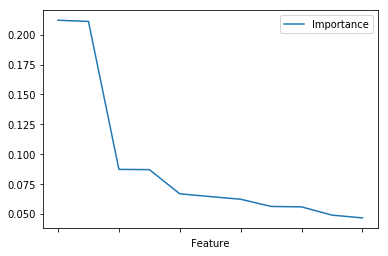

In [64]:
feature_importance.plot('Feature', 'Importance')

In [ ]:
#Add 1 for dates where there is discount and 0 when there is no discount
#Add duration between dates where there is discount
day1 = np.timedelta64(1, 'D')
last_date = np.datetime64()
last_store = 0
res = []

for v,d in zip(df['event'].values, df.date.values):
    if v: last_date = d
    res.append(((d-last_date).astype('timedelta64[D]') / day1))
    
df[pre+fld] = res

#do it backward and forward